In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

plt.style.use("default")
sns.set_theme()


Matplotlib is building the font cache; this may take a moment.


In [10]:
# 2. Leitura dos arquivos
path_flights = r"C:\Users\Amilt\OneDrive\FIAP-MLET\fase_3\MLET03\bases\flights.csv"
path_airlines = r"C:\Users\Amilt\OneDrive\FIAP-MLET\fase_3\MLET03\bases\airlines.csv"
path_airports = r"C:\Users\Amilt\OneDrive\FIAP-MLET\fase_3\MLET03\bases\airports.csv"

flights = pd.read_csv(path_flights)
airlines = pd.read_csv(path_airlines)
airports = pd.read_csv(path_airports)

flights.shape, airlines.shape, airports.shape


C:\Users\Amilt\AppData\Local\Temp\ipykernel_25472\1225413437.py:6: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  flights = pd.read_csv(path_flights)


((5819079, 31), (14, 2), (322, 7))

In [11]:
# Olhando o cabeçalho
flights.head()


,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# Informação geral e tipos
flights.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
 #   Column               Dtype  
---  ------               -----  
 0   YEAR                 int64  
 1   MONTH                int64  
 2   DAY                  int64  
 3   DAY_OF_WEEK          int64  
 4   AIRLINE              object 
 5   FLIGHT_NUMBER        int64  
 6   TAIL_NUMBER          object 
 7   ORIGIN_AIRPORT       object 
 8   DESTINATION_AIRPORT  object 
 9   SCHEDULED_DEPARTURE  int64  
 10  DEPARTURE_TIME       float64
 11  DEPARTURE_DELAY      float64
 12  TAXI_OUT             float64
 13  WHEELS_OFF           float64
 14  SCHEDULED_TIME       float64
 15  ELAPSED_TIME         float64
 16  AIR_TIME             float64
 17  DISTANCE             int64  
 18  WHEELS_ON            float64
 19  TAXI_IN              float64
 20  SCHEDULED_ARRIVAL    int64  
 21  ARRIVAL_TIME         float64
 22  ARRIVAL_DELAY        float64
 23  DIVERTED             int64  
 24

In [13]:
# Estatísticas descritivas numéricas
flights.describe().T


,count,mean,std,min,25%,50%,75%,max
YEAR,5819079.0,2015.000000,0.000000,2015.0,2015.0,2015.0,2015.0,2015.0
MONTH,5819079.0,6.524085,3.405137,1.0,4.0,7.0,9.0,12.0
DAY,5819079.0,15.704594,8.783425,1.0,8.0,16.0,23.0,31.0
DAY_OF_WEEK,5819079.0,3.926941,1.988845,1.0,2.0,4.0,6.0,7.0
FLIGHT_NUMBER,5819079.0,2173.092742,1757.063999,1.0,730.0,1690.0,3230.0,9855.0
SCHEDULED_DEPARTURE,5819079.0,1329.602470,483.751821,1.0,917.0,1325.0,1730.0,2359.0
DEPARTURE_TIME,5732926.0,1335.204439,496.423260,1.0,921.0,1330.0,1740.0,2400.0
DEPARTURE_DELAY,5732926.0,9.370158,37.080942,-82.0,-5.0,-2.0,7.0,1988.0
TAXI_OUT,5730032.0,16.071662,8.895574,1.0,11.0,14.0,19.0,225.0
WHEELS_OFF,5730032.0,1357.170841,498.009356,1.0,935.0,1343.0,1754.0,2400.0


In [14]:
# Percentual de nulos por coluna
null_pct = flights.isna().mean().sort_values(ascending=False)
null_pct


CANCELLATION_REASON    0.984554
LATE_AIRCRAFT_DELAY    0.817250
WEATHER_DELAY          0.817250
AIRLINE_DELAY          0.817250
AIR_SYSTEM_DELAY       0.817250
SECURITY_DELAY         0.817250
ELAPSED_TIME           0.018056
AIR_TIME               0.018056
ARRIVAL_DELAY          0.018056
WHEELS_ON              0.015898
TAXI_IN                0.015898
ARRIVAL_TIME           0.015898
WHEELS_OFF             0.015303
TAXI_OUT               0.015303
DEPARTURE_TIME         0.014805
DEPARTURE_DELAY        0.014805
TAIL_NUMBER            0.002530
SCHEDULED_TIME         0.000001
DESTINATION_AIRPORT    0.000000
DAY                    0.000000
DAY_OF_WEEK            0.000000
AIRLINE                0.000000
FLIGHT_NUMBER          0.000000
MONTH                  0.000000
ORIGIN_AIRPORT         0.000000
SCHEDULED_DEPARTURE    0.000000
YEAR                   0.000000
SCHEDULED_ARRIVAL      0.000000
DISTANCE               0.000000
DIVERTED               0.000000
CANCELLED              0.000000
dtype: f

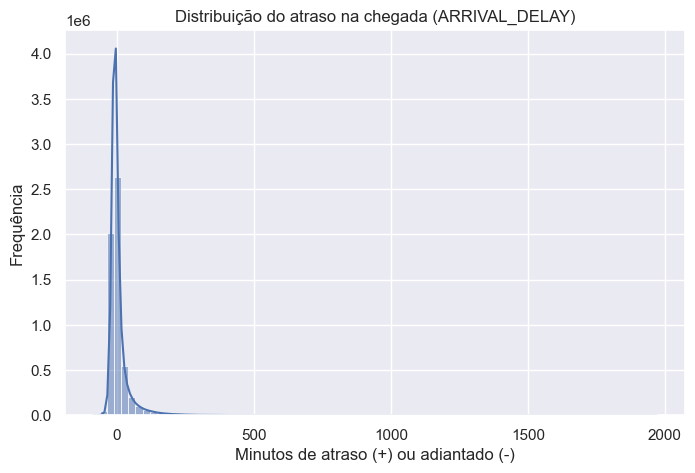

In [15]:
# Visualização dos principais atrasos
plt.figure(figsize=(8,5))
sns.histplot(flights["ARRIVAL_DELAY"].dropna(), bins=80, kde=True)
plt.title("Distribuição do atraso na chegada (ARRIVAL_DELAY)")
plt.xlabel("Minutos de atraso (+) ou adiantado (-)")
plt.ylabel("Frequência")
plt.show()


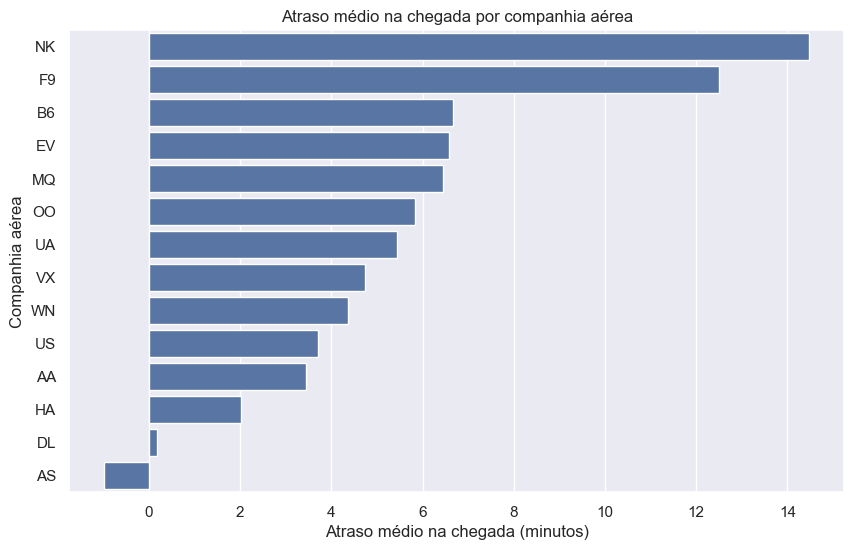

In [19]:
# Atraso médio por companhia aérea
# join com airlines para nome legível
delay_by_airline = (
    flights.groupby("AIRLINE", as_index=False)["ARRIVAL_DELAY"]
        .mean()
        .sort_values("ARRIVAL_DELAY", ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=delay_by_airline,
    y="AIRLINE",
    x="ARRIVAL_DELAY"
)
plt.title("Atraso médio na chegada por companhia aérea")
plt.xlabel("Atraso médio na chegada (minutos)")
plt.ylabel("Companhia aérea")
plt.show()


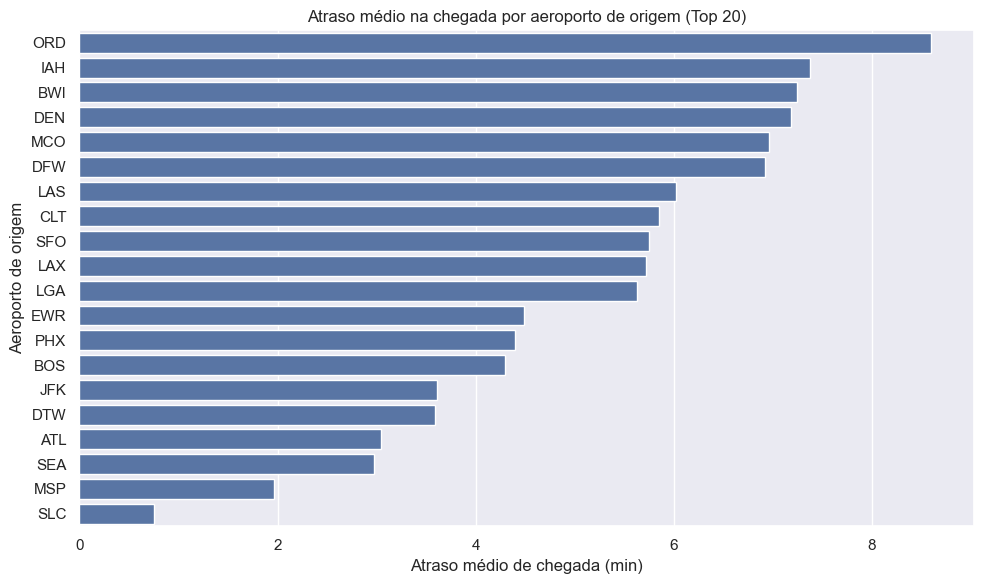

In [20]:
# Atraso médio por aeroporto de origem (top 20 mais movimentados)
top_origens = (
    flights["ORIGIN_AIRPORT"]
    .value_counts()
    .head(20)
    .index
)

delay_by_origin = (
    flights[flights["ORIGIN_AIRPORT"].isin(top_origens)]
    .groupby("ORIGIN_AIRPORT")["ARRIVAL_DELAY"]
    .mean()
    .reset_index()
    .merge(airports[["IATA_CODE", "AIRPORT", "CITY", "STATE"]],
           left_on="ORIGIN_AIRPORT", right_on="IATA_CODE", how="left")
    .sort_values("ARRIVAL_DELAY", ascending=False)
)

plt.figure(figsize=(10,6))
sns.barplot(
    data=delay_by_origin,
    y="ORIGIN_AIRPORT",
    x="ARRIVAL_DELAY"
)
plt.title("Atraso médio na chegada por aeroporto de origem (Top 20)")
plt.xlabel("Atraso médio de chegada (min)")
plt.ylabel("Aeroporto de origem")
plt.tight_layout()
plt.show()


In [21]:
# Remover linhas sem informação de atraso
flights_model = flights.dropna(subset=["ARRIVAL_DELAY"]).copy()

# Variável alvo binária
flights_model["IS_DELAYED"] = (flights_model["ARRIVAL_DELAY"] > 15).astype(int)

flights_model["IS_DELAYED"].value_counts(normalize=True)


IS_DELAYED
0    0.820879
1    0.179121
Name: proportion, dtype: float64

In [22]:
# Criar coluna de data
flights_model["FLIGHT_DATE"] = pd.to_datetime(
    flights_model[["YEAR", "MONTH", "DAY"]]
)

# Hora de saída agendada (SCHEDULED_DEPARTURE é HHMM)
flights_model["SCHED_DEP_HOUR"] = (
    flights_model["SCHEDULED_DEPARTURE"]
    .fillna(0)
    .astype(int)
    .floordiv(100)
)

# Período do dia
def period_of_day(hour):
    if hour < 6:
        return "dawn"       # madrugada
    elif hour < 12:
        return "morning"
    elif hour < 18:
        return "afternoon"
    else:
        return "night"

flights_model["DEP_PERIOD"] = flights_model["SCHED_DEP_HOUR"].apply(period_of_day)


In [24]:
target = "IS_DELAYED"

numeric_features = [
    "SCHED_DEP_HOUR",
    "DISTANCE",
    "DAY_OF_WEEK",
    "MONTH"
]

categorical_features = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "DEP_PERIOD"
]

# Amostra opcional para reduzir tamanho (caso o dataset seja muito grande)
# descomente se estiver pesado
# flights_model = flights_model.sample(300_000, random_state=42)

X = flights_model[numeric_features + categorical_features]
y = flights_model[target]


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train.shape, X_test.shape


((4571206, 8), (1142802, 8))

In [26]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


In [27]:
def evaluate_classifier(name, model, X_train, X_test, y_train, y_test):
    print(f"\n========== {name} ==========")
    y_pred = model.predict(X_test)

    print("\nClassification report:")
    print(classification_report(y_test, y_pred, digits=4))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Matriz de confusão - {name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()

    # Probabilidades para ROC-AUC (se o modelo permitir)
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_prob)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        print(f"ROC-AUC: {auc:.4f}")

        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        plt.plot([0,1], [0,1], "--", color="gray")
        plt.xlabel("Falso positivo")
        plt.ylabel("Verdadeiro positivo")
        plt.title(f"Curva ROC - {name}")
        plt.legend()
        plt.show()


In [ ]:
#verifiquei uma coluna que estava zuada

for col in X_train.columns:
    tipos = X_train[col].dropna().apply(type).unique()
    if len(tipos) > 1:
        print(col, "->", tipos)

ORIGIN_AIRPORT -> [<class 'str'> <class 'int'>]
DESTINATION_AIRPORT -> [<class 'str'> <class 'int'>]


In [34]:
#converti para string antes do treinamento
colunas_categoricas = [
    "AIRLINE",
    "ORIGIN_AIRPORT",
    "DESTINATION_AIRPORT",
    "DAY_OF_WEEK"      
]

for col in colunas_categoricas:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)


========== Logistic Regression ==========

Classification report:
              precision    recall  f1-score   support

           0     0.8209    0.9999    0.9016    938102
           1     0.4521    0.0004    0.0008    204700

    accuracy                         0.8209   1142802
   macro avg     0.6365    0.5002    0.4512   1142802
weighted avg     0.7549    0.8209    0.7403   1142802



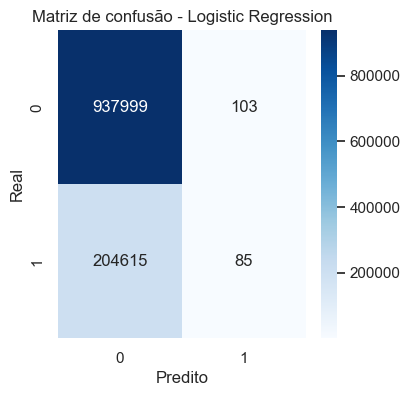

ROC-AUC: 0.6442


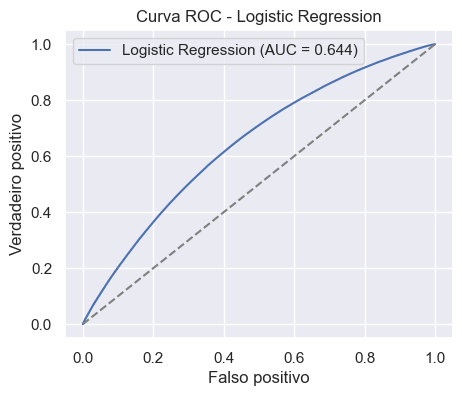

In [35]:
log_reg_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=-1))
])

log_reg_clf.fit(X_train, y_train)
evaluate_classifier("Logistic Regression", log_reg_clf, X_train, X_test, y_train, y_test)


In [ ]:
rf_clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        n_jobs=-1,
        random_state=42,
        class_weight="balanced_subsample"
    ))
])

rf_clf.fit(X_train, y_train)
evaluate_classifier("Random Forest", rf_clf, X_train, X_test, y_train, y_test)


In [ ]:
# Agregação por aeroporto de origem
airport_stats = (
    flights_model
    .groupby("ORIGIN_AIRPORT")
    .agg(
        mean_arr_delay=("ARRIVAL_DELAY", "mean"),
        mean_dep_delay=("DEPARTURE_DELAY", "mean"),
        total_flights=("ARRIVAL_DELAY", "count")
    )
    .reset_index()
)

airport_stats.head()


In [ ]:
# Merge com info geográfica dos aeroportos (opcional)
airport_stats = airport_stats.merge(
    airports[["IATA_CODE", "AIRPORT", "CITY", "STATE", "LATITUDE", "LONGITUDE"]],
    left_on="ORIGIN_AIRPORT",
    right_on="IATA_CODE",
    how="left"
)

airport_stats.head()


NameError: name 'airport_stats' is not defined

In [ ]:
# Features numéricas para clusterizar
cluster_features = ["mean_arr_delay", "mean_dep_delay", "total_flights"]

X_cluster = airport_stats[cluster_features].fillna(0).copy()

scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)


In [ ]:
# KMeans com 4 clusters (pode testar outros k)
kmeans = KMeans(n_clusters=4, random_state=42)
airport_stats["CLUSTER"] = kmeans.fit_predict(X_cluster_scaled)

airport_stats[["ORIGIN_AIRPORT", "AIRPORT", "STATE", "mean_arr_delay", "mean_dep_delay", "total_flights", "CLUSTER"]].head(20)


In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=airport_stats,
    x="mean_dep_delay",
    y="mean_arr_delay",
    hue="CLUSTER",
    size="total_flights",
    sizes=(20, 200),
    alpha=0.8
)
plt.title("Clusters de aeroportos por perfil de atraso")
plt.xlabel("Atraso médio na partida (min)")
plt.ylabel("Atraso médio na chegada (min)")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [ ]:
# Atrasos por período do dia
delay_by_period = flights_model.groupby("DEP_PERIOD")["ARRIVAL_DELAY"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=delay_by_period, x="DEP_PERIOD", y="ARRIVAL_DELAY", order=["dawn", "morning", "afternoon", "night"])
plt.title("Atraso médio por período do dia")
plt.xlabel("Período do dia")
plt.ylabel("Atraso médio de chegada (min)")
plt.show()


In [ ]:
# Atrasos por mês (sazonalidade)
delay_by_month = flights_model.groupby("MONTH")["ARRIVAL_DELAY"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(data=delay_by_month, x="MONTH", y="ARRIVAL_DELAY", marker="o")
plt.title("Atraso médio por mês")
plt.xlabel("Mês")
plt.ylabel("Atraso médio de chegada (min)")
plt.xticks(range(1,13))
plt.show()
